[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/khetansarvesh/CV/blob/main/data-augmentation/VQ_VAE_CNN.ipynb)


In [ ]:
# Modelling Imports
import torch
import torch.nn as nn

# Training Imports
from tqdm import tqdm
from torch.optim import Adam

# Inference Imports
import torchvision
import numpy as np
from matplotlib import pyplot as plt

In [8]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Dataset

In [1]:
from torchvision import datasets, transforms
from torch.utils.data.dataset import Dataset
from torch.utils.data import DataLoader

In [2]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))]) # Define the transformation to normalize the data between 1 and -1 (mean = 0.5 and variance = 0.5 will transform to values between 1 and -1)
mnist = datasets.MNIST(root='./data', train=True, transform=transform, download=True) # downloading the MNIST train dataset and then applying some transformations
mnist_loader = DataLoader(dataset=mnist, batch_size=64, shuffle=True, num_workers=0) # loading the downloaded dataset

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:00<00:00, 36970910.41it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 7039089.65it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:00<00:00, 12033099.19it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 4080216.06it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



# Modelling

In [6]:
class VQVAE(nn.Module):
    def __init__(self):
        super(VQVAE, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, 4, stride=2, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.Conv2d(16, 4, 4, stride=2, padding=1),
            nn.BatchNorm2d(4),
            nn.ReLU(),
        )

        self.pre_quant_conv = nn.Conv2d(4, 2, kernel_size=1)
        self.embedding = nn.Embedding(num_embeddings=3, embedding_dim=2)
        self.post_quant_conv = nn.Conv2d(2, 4, kernel_size=1)

        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(4, 16, 4, stride=2, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.ConvTranspose2d(16, 1, 4, stride=2, padding=1),
            nn.Tanh(),
        )


    def forward(self, x):
        # B, C, H, W
        encoded_output = self.encoder(x)
        quant_input = self.pre_quant_conv(encoded_output)

        ## Quantization
        B, C, H, W = quant_input.shape
        quant_input = quant_input.permute(0, 2, 3, 1)
        quant_input = quant_input.reshape((quant_input.size(0), -1, quant_input.size(-1)))

        # Compute pairwise distances
        dist = torch.cdist(quant_input, self.embedding.weight[None, :].repeat((quant_input.size(0), 1, 1)))

        # Find index of nearest embedding
        min_encoding_indices = torch.argmin(dist, dim=-1)

        # Select the embedding weights
        quant_out = torch.index_select(self.embedding.weight, 0, min_encoding_indices.view(-1))
        quant_input = quant_input.reshape((-1, quant_input.size(-1)))

        # Compute losses
        beta = 0.2
        commitment_loss = torch.mean((quant_out.detach() - quant_input)**2)
        codebook_loss = torch.mean((quant_out - quant_input.detach())**2)
        quantize_losses = codebook_loss + beta*commitment_loss

        # Ensure straight through gradient
        quant_out = quant_input + (quant_out - quant_input).detach()

        # Reshaping back to original input shape
        quant_out = quant_out.reshape((B, H, W, C)).permute(0, 3, 1, 2)
        min_encoding_indices = min_encoding_indices.reshape((-1, quant_out.size(-2), quant_out.size(-1)))


        ## Decoder part
        decoder_input = self.post_quant_conv(quant_out)
        output = self.decoder(decoder_input)
        return output, quantize_losses

# Training

In [10]:
model = VQVAE().to(device)
optimizer = Adam(model.parameters(), lr=1E-3)
criterion = torch.nn.MSELoss()

In [11]:
for epoch_idx in range(20):
    for im, label in tqdm(mnist_loader):
        im = im.float().to(device)
        optimizer.zero_grad()
        out, quantize_loss = model(im)

        recon_loss = criterion(out, im)
        loss = recon_loss + quantize_loss
        loss.backward()
        optimizer.step()
    print('Finished epoch {}'.format(epoch_idx+1))

100%|██████████| 938/938 [00:40<00:00, 23.42it/s]


Finished epoch 1


100%|██████████| 938/938 [00:41<00:00, 22.55it/s]


Finished epoch 2


100%|██████████| 938/938 [00:40<00:00, 23.00it/s]


Finished epoch 3


100%|██████████| 938/938 [00:37<00:00, 24.92it/s]


Finished epoch 4


100%|██████████| 938/938 [00:38<00:00, 24.53it/s]


Finished epoch 5


100%|██████████| 938/938 [00:39<00:00, 23.80it/s]


Finished epoch 6


100%|██████████| 938/938 [00:37<00:00, 25.16it/s]


Finished epoch 7


100%|██████████| 938/938 [00:37<00:00, 24.90it/s]


Finished epoch 8


100%|██████████| 938/938 [00:41<00:00, 22.82it/s]


Finished epoch 9


100%|██████████| 938/938 [00:38<00:00, 24.47it/s]


Finished epoch 10


100%|██████████| 938/938 [00:41<00:00, 22.86it/s]


Finished epoch 11


100%|██████████| 938/938 [00:39<00:00, 24.01it/s]


Finished epoch 12


100%|██████████| 938/938 [00:38<00:00, 24.18it/s]


Finished epoch 13


100%|██████████| 938/938 [00:38<00:00, 24.27it/s]


Finished epoch 14


100%|██████████| 938/938 [00:38<00:00, 24.35it/s]


Finished epoch 15


100%|██████████| 938/938 [00:39<00:00, 23.75it/s]


Finished epoch 16


100%|██████████| 938/938 [00:38<00:00, 24.19it/s]


Finished epoch 17


100%|██████████| 938/938 [00:38<00:00, 24.17it/s]


Finished epoch 18


100%|██████████| 938/938 [00:37<00:00, 24.71it/s]


Finished epoch 19


100%|██████████| 938/938 [00:38<00:00, 24.44it/s]

Finished epoch 20


# Inference

In [13]:
# Getting 100 random indexes
idxs = torch.randint(0, len(mnist)-1, (100, ))

# using these indexes to get images from mnist dataset and concatenating them
test_ims = torch.cat([mnist[idx][0][None, :] for idx in idxs]).float()

# generating images for the above test dataset
generated_im,_ = model(test_ims)

In [14]:
generated_im = torch.clamp(generated_im, -1., 1.).detach().cpu() # clamping the generated images
generated_im = 0.5*generated_im + 0.5 #detransforming the images from [-1,1] to [0,1]

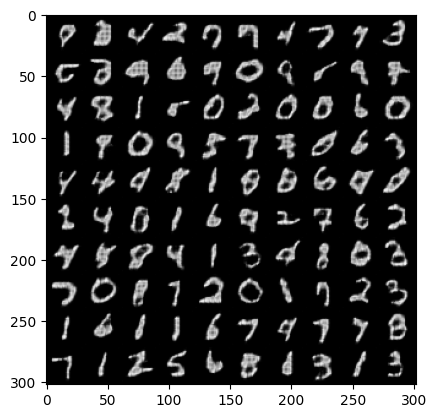

In [17]:
# now printing the predicted images
grid = torchvision.utils.make_grid(generated_im, nrow=10)
img = torchvision.transforms.ToPILImage()(grid)
plt.imshow(img, cmap='gray')